# 투빅스 19기 5주차 Ensemble 과제

### 리뷰한 대회 : 운동 동작 분류 AI 경진 대회

#### 코드 링크 : https://dacon.io/competitions/official/235689/data

Private 41위, Public 점수 :0.0.66207, XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

# 데이터 불러오기

In [ ]:
train_features = pd.read_csv('/content/drive/MyDrive/DataAnalysis/운동 동작 분류 AI 경진대회/data/train_features.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/DataAnalysis/운동 동작 분류 AI 경진대회/data/train_labels.csv')
test_features = pd.read_csv('/content/drive/MyDrive/DataAnalysis/운동 동작 분류 AI 경진대회/data/test_features.csv')
submission = pd.read_csv('/content/drive/MyDrive/DataAnalysis/운동 동작 분류 AI 경진대회/data/sample_submission.csv')

데이터는 3축의 가속도계(accelerometer)와 3축의 자이로스코프(gyroscope)를 활용해 측정된 센서 데이터이다.  
각 id 별로 600 time 간의 동작 데이터이며 총 id 개수는 3125개로 train 데이터에는 1875000개의 데이터가 존재한다.  
그리고 test 데이터에는 782개의 id로 469200개의 데이터가 존재한다.

* train_features.csv (1875000, 8)
* train_labels.csv (3125, 3) - id 별 동작과 동작 label(61개)
* test_features.csv (469200, 8)
* sample_submission.csv (782, 62) - id별 동작을 예측해 작성하는 csv 

# Feature Engineering

4초씩 나눠서 3등분 한다,

0.02초씩 측정된 운동에 따른 acc, gy의 x, y, z 축에 센서에 따른 측정 값이다. 

- Max : 최댓값 -> 선택 O

- Min : 최소값 -> 선택 O

- Mean : 평균값 -> 선택 O

- Q1 : 1사분위수 -> 선택 O

- Q2 : 중앙값 -> 선택 O

- Q3 : 3사분위수 -> 선택 O

- IQR : Q3 - Q1 -> 선택 O

- MAD : Mean Absolute Deviation -> 선택 O

- RMS : Root Mean Squre -> 선택 O

- MM : Min - Max -> 선택 X

- ZCR : Zero Crossing Rate -> 선택 O

- SMA : Signal Magnitude Area -> 선택 X

- MCR : Mean Crossing Rate (ZCR에 영감을 받아 직접 만든 feature) -> 선택 X

참고: https://www.researchgate.net/publication/311591075_Feature_Analysis_to_Human_Activity_Recognition

train과 test 데이터들을 4초씩 3등분한 후 각 3등분한 값들마다 위의 통계량 값들을 구하여 features를 재정의해준다.  
여기서 max, min, mean, Q1,Q2,Q3와 같은 기본적인 통계 개념은 설명에 생략하고 나머지를 간단히 설명하도록 하겠다.  

* MAD : Mean Absolute Deviation(표준 절대 편차) = 관측치의 평균과 개별 관측치 사이의 거리 평균이다. 이때 각 거리는 절대값으로 모두 0이상의 값으로 표시된다.
* RMS : Root Mean Square(제곱평균제곱근) = 변화하는 값의 크기에 대한 통계적 척도로 말 그대로 관측치의 제곱값의 평균에 root를 취해준 값이다.
* ZCR : Zero Crossing Rate(영교차율) = 관측치의 부호가 0을 지나는 즉, 부호가 바뀌는 비율을 의미한다.

(선택되지 않은 feature들은 따로 설명 x)

In [2]:
# 컬럼 생성
cols = ['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']
vals = ['max', 'min', 'mean', 'Q1', "Q2", "Q3", "IQR", "mad", "rms", "zcr"]
seconds = [str(i) for i in range(1, 4)]
res_cols = []
for col in cols:
    for val in vals:
        for second in seconds:
              res_cols.append(col + '_' + val + '_' + second)

# cols = ['acc_sma', 'gy_sma']
# for col in cols:
#   for second in seconds:
#     res_cols.append(col + '_' + second)

In [3]:
res_cols

['acc_x_max_1',
 'acc_x_max_2',
 'acc_x_max_3',
 'acc_x_min_1',
 'acc_x_min_2',
 'acc_x_min_3',
 'acc_x_mean_1',
 'acc_x_mean_2',
 'acc_x_mean_3',
 'acc_x_Q1_1',
 'acc_x_Q1_2',
 'acc_x_Q1_3',
 'acc_x_Q2_1',
 'acc_x_Q2_2',
 'acc_x_Q2_3',
 'acc_x_Q3_1',
 'acc_x_Q3_2',
 'acc_x_Q3_3',
 'acc_x_IQR_1',
 'acc_x_IQR_2',
 'acc_x_IQR_3',
 'acc_x_mad_1',
 'acc_x_mad_2',
 'acc_x_mad_3',
 'acc_x_rms_1',
 'acc_x_rms_2',
 'acc_x_rms_3',
 'acc_x_zcr_1',
 'acc_x_zcr_2',
 'acc_x_zcr_3',
 'acc_y_max_1',
 'acc_y_max_2',
 'acc_y_max_3',
 'acc_y_min_1',
 'acc_y_min_2',
 'acc_y_min_3',
 'acc_y_mean_1',
 'acc_y_mean_2',
 'acc_y_mean_3',
 'acc_y_Q1_1',
 'acc_y_Q1_2',
 'acc_y_Q1_3',
 'acc_y_Q2_1',
 'acc_y_Q2_2',
 'acc_y_Q2_3',
 'acc_y_Q3_1',
 'acc_y_Q3_2',
 'acc_y_Q3_3',
 'acc_y_IQR_1',
 'acc_y_IQR_2',
 'acc_y_IQR_3',
 'acc_y_mad_1',
 'acc_y_mad_2',
 'acc_y_mad_3',
 'acc_y_rms_1',
 'acc_y_rms_2',
 'acc_y_rms_3',
 'acc_y_zcr_1',
 'acc_y_zcr_2',
 'acc_y_zcr_3',
 'acc_z_max_1',
 'acc_z_max_2',
 'acc_z_max_3',
 'ac

최종 feature들은 위와 같이 3등분한 값들에 대한 통계량 값으로 표시된다.  
이제 train과 test별로 각각의 정의한 통계량 값들을 적용시켜준다.  
이때 총 600개의 time데이터를 3등분 했기 때문에 만들어진 200개의 데이터에 대해서 각각의 col마다 (-1,200)으로 reshape 시켜준다. 그리고 이들을 한번더 (-1,3)으로 reshape해준 뒤 최종 train_***, test_***으로 정의해준다.  
최종적으로 정의한 모든 배열들을 합쳐준 뒤 train_result와 test_result로 정의해준다.  
  
(코드를 작성하신 분이 사용하지 않은 통계량을 따로 주석처리하였지만 이는 모두 제거하였음. 처음의 링크에 SMA, MM 등 사용하지 않은 코드들도 따로 정의해두었음)

In [ ]:
# train 용
cols = ['acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']
train_result = []
test_result = []

for col in cols:
    
    # max
    train_max = train_features[[col]].values.reshape(-1,200).max(axis=1)
    train_max = train_max.reshape(-1,3)

    # min
    train_min = train_features[[col]].values.reshape(-1,200).min(axis=1)
    train_min = train_min.reshape(-1,3)

    # mean
    train_mean = train_features[[col]].values.reshape(-1,200).mean(axis=1)
    train_mean = train_mean.reshape(-1,3)

    # Q1, Q2, Q3
    train_Q1 = []
    train_Q2 = []
    train_Q3 = []
    for i in (train_features[[col]].values.reshape(-1,200)):
        train_Q1.append(np.percentile(i, 25))
        train_Q2.append(np.percentile(i, 50))
        train_Q3.append(np.percentile(i, 75))

        train_Q1 = np.array(train_Q1).reshape(-1,3)
        train_Q2 = np.array(train_Q2).reshape(-1,3)
        train_Q3 = np.array(train_Q3).reshape(-1,3)

    # IQR
    train_IQR = train_Q3 - train_Q1

    # mad
    train_mad = (abs(train_features[[col]].values.reshape(-1,200) - train_features[[col]].values.reshape(-1,200).mean(axis=1).reshape(-1,1))).mean(axis=1).reshape(-1,3)

    # rms
    train_rms = np.square((train_features[[col]].values.reshape(-1,200)**2).mean(axis=1)).reshape(-1,3)

    # zcr
    train_zcr = ((train_features[[col]].values.reshape(-1,200)[:,:-1] * train_features[[col]].values.reshape(-1,200)[:,1:] < 0).sum(axis=1) / 200 ).reshape(-1,3)

    train_val = np.concatenate([train_max, train_min, train_mean, train_Q1, train_Q2, train_Q3, train_IQR, train_mad, train_rms, train_zcr],axis=1)
    train_result.append(train_val)

In [ ]:
for col in cols:
    # test 용
    test_max = test_features[[col]].values.reshape(-1,200).max(axis=1)
    test_max = test_max.reshape(-1,3)

    test_min = test_features[[col]].values.reshape(-1,200).min(axis=1)
    test_min = test_min.reshape(-1,3)

    test_mean = test_features[[col]].values.reshape(-1,200).mean(axis=1)
    test_mean = test_mean.reshape(-1,3)

    # Q1, Q2, Q3
    test_Q1 = []
    test_Q2 = []
    test_Q3 = []
    for i in (test_features[[col]].values.reshape(-1,200)):
        test_Q1.append(np.percentile(i, 25))
        test_Q2.append(np.percentile(i, 50))
        test_Q3.append(np.percentile(i, 75))

        test_Q1 = np.array(test_Q1).reshape(-1,3)
        test_Q2 = np.array(test_Q2).reshape(-1,3)
        test_Q3 = np.array(test_Q3).reshape(-1,3)

    # IQR
    test_IQR = test_Q3 - test_Q1

    # mad
    test_mad = (abs(test_features[[col]].values.reshape(-1,200) - test_features[[col]].values.reshape(-1,200).mean(axis=1).reshape(-1,1))).mean(axis=1).reshape(-1,3)

    # rms
    test_rms = np.square((test_features[[col]].values.reshape(-1,200)**2).mean(axis=1)).reshape(-1,3)

    # zcr
    test_zcr = ((test_features[[col]].values.reshape(-1,200)[:,:-1] * test_features[[col]].values.reshape(-1,200)[:,1:] < 0).sum(axis=1) / 200 ).reshape(-1,3)

    test_val = np.concatenate([test_max, test_min, test_mean, test_Q1, test_Q2, test_Q3, test_IQR, test_mad, test_rms, test_zcr],axis=1)
    test_result.append(test_val)

In [ ]:
train_result = np.concatenate(train_result,axis=1)
test_result = np.concatenate(test_result,axis=1)

train_features_3 = pd.DataFrame(train_result, columns=res_cols)
test_features_3 = pd.DataFrame(test_result, columns=res_cols)

In [ ]:
train_val = train_features.drop('time', axis=1).groupby('id').agg(['mean', 'min', 'max', 'median']).values
test_val = test_features.drop('time', axis=1).groupby('id').agg(['mean', 'min', 'max', 'median']).values

ag_cols = ['acc_x','acc_y','acc_z','gy_x','gy_y','gy_z']
des_cols = ['mean', 'min', 'max', 'median']
result_cols = []

for ag_col in ag_cols:
    for des_col in des_cols:
        result_cols.append(ag_col+'_'+des_col)

train_mean_min_max_median_feature = pd.DataFrame(data = train_val, columns = result_cols)
test_mean_min_max_median_feature = pd.DataFrame(data = test_val, columns = result_cols)

train_mean_min_max_median_label = train_labels[['label']]
train_mean_min_max_median_label_dummy = pd.get_dummies(train_labels['label'])

In [ ]:
train_features_3.head()

acc_x_max_1  acc_x_max_2  acc_x_max_3  ...  gy_z_zcr_1  gy_z_zcr_2  gy_z_zcr_3
0     1.343113     1.284556     1.344268  ...       0.100       0.075       0.070
1    -0.059166     0.316553     1.234020  ...       0.035       0.040       0.070
2     1.219836     1.003180     1.024170  ...       0.140       0.150       0.145
3    -0.679208    -0.622250    -0.651887  ...       0.045       0.150       0.060
4     0.599720    -0.335596    -0.280967  ...       0.065       0.080       0.085

[5 rows x 180 columns]

위는 전처리 후 최종 train_features_3의 모습이다.

# 각각의 모델 평가 (튜닝 전)

1. Stratified K-Fold

    교차검증은 머신러닝에서 train과 test로 나누어 훈련하는 과정에서 훈련 때 train 데이터에 과도하게 초점을 맞춰 훈련되어 나타나는 과적합을 방지하기 위한 방법이다.

    대표적인 교차 검증 방법중 하나인 stratified K Fold는 target에 속성값의 개수를 동일하게 가져감으로써 K-Fold와 같이 데이터가 한곳으로 몰리는 것을 방지해준다. 분류에서의 교차검증으로 자주 활용된다.
  
    **해당 코드에서는 데이터 분할 수를 5로 설정하였고 shuffle을 True로 설정하여 데이터 분할 전 데이터들을 적절히 shuffle하기로 하였다.**  
  
2. RandomForestClassifier

    결정트리에서의 훈련 데이터가 과적합되는 문제점을 방지하기 위한 하나의 방법으로 Random Forest가 소개된다. 이는 여러 DT들이 결합되어 있다고 생각해도 무방하며 각각의 모델들을 훈련하며 예측된 결과를 평균냄으로써 최종 결과값을 산출한다.  
  
    random forest의 중요한 파라미터로는 생성할 tree의 개수(n_estimators), tree의 최대 깊이(max_depth), 노드를 분할하기 위한 샘플 데이터 수(min_samples_split) 등이 있다.
  
    **해당 코드에서는 모든 값들을 기본으로 설정하여 n_estimators는 default값으로 10, min_samples_split = 2, max_depth = None로 말할 수 있다.**  
  
3. lightgbm

    GBM(Gradient Boosting Model)은 tree 기반 알고리즘으로 틀린부분에 가중치를 더하며 진행해나가는 방식이다. 여기서 lightgbm은 정답과 오답의 차이를 반복적으로 training하여 모델을 개선해나가는 방식을 사용한다. 이때 기존의 균형 트리분할 방식과는 달리 최대 손실값을 가지는 leaf node에만 지속적인 분할을 통해 예측 오류 손실을 최소화하고 더 빠른 학습과 예측 수행시간을 가질 수 있다는 장점이 있다.
    
    lightgbm의 대표적인 몇가지 parameters는 tree 개수(n_estimators), 학습률(learning-rate), 최대 깊이(max_depth), regularization 적용값(L1, L2) 등이 있다.
    
    **해당 코드에서는 모든 값들을 기본으로 설정하였고(n = 100, learning-rate = 0.1, max_depth = -1 ..) tree-method와 gpu-hist로 속도에 영향을 미치는 분기 포인트를 잡을 때 히스토그램을 사용하도록 설정하였다. predictor를 통해 gpu로 설정해주었다.  
    
4. xgb

    XGBoost는 GBM(Gradient Boosting Model)에 기반으로 하고 있지만 단점인 느린 수행시간, 과적합 방지를 해결하기 위해 제시된 알고리즘이다. 따라서 높은 예측 성능, 과적합 규제, GBM 대비 빠른 수행 시간이 그 장점이라고 말할 수 있다.
    
    xgb의 대표적인 몇가지 parameters는 학습률(learning-rate), 생성할 weak learner 수(n_estimators), 최대 깊이(max_depth), regularization 적용값(L1, L2) 등이 있다.
    
    **해당 코드에서는 모든 값들을 기본으로 설정하였고(n = 100, learning-rate = 0.1, max_depth = -1 ..) 마찬가지로 tree-method와 gpu-hist로 속도에 영향을 미치는 분기 포인트를 잡을 때 히스토그램을 사용하도록 설정하였다. predictor를 통해 gpu로 설정해주었다.**

In [ ]:
# 데이터 분할
from sklearn.model_selection import StratifiedKFold

# 모델
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

# 속도 체크 - tqdm은 작업의 진행상황을 알 수 있게 해주는 모듈이다.
from tqdm import tqdm_notebook

n_split = 5
skf = StratifiedKFold(n_splits = n_split, shuffle=True, random_state=22)

rf_oof_train = np.zeros(train_mean_min_max_median_label_dummy.shape)
lgbm_oof_train = np.zeros(train_mean_min_max_median_label_dummy.shape)
xgb_oof_train = np.zeros(train_mean_min_max_median_label_dummy.shape)
lg_oof_train = np.zeros(train_mean_min_max_median_label_dummy.shape)

rf = RandomForestClassifier(random_state=22)
lgbm = lgbm.LGBMClassifier(random_state=22, 
                           tree_method='gpu_hist', 
                           predictor='gpu_predictor')
xgb = xgb.XGBClassifier(random_state=22, 
                        tree_method='gpu_hist', 
                        predictor='gpu_predictor')
lg = LogisticRegression(random_state=22)

for trn_idx, val_idx in tqdm_notebook(skf.split(train_features_3, train_mean_min_max_median_label)):
    trn_data, trn_label = train_features_3.iloc[trn_idx], train_mean_min_max_median_label.iloc[trn_idx]
    val_data, val_label = train_features_3.iloc[val_idx], train_mean_min_max_median_label.iloc[val_idx]

    rf.fit(trn_data, trn_label)
    rf_valid_pred = rf.predict_proba(val_data)
    rf_oof_train[val_idx] = rf_valid_pred

    lgbm.fit(trn_data, trn_label)
    lgbm_valid_pred = lgbm.predict_proba(val_data)
    lgbm_oof_train[val_idx] = lgbm_valid_pred

    xgb.fit(trn_data, trn_label)
    xgb_valid_pred = xgb.predict_proba(val_data)
    xgb_oof_train[val_idx] = xgb_valid_pred

    lg.fit(trn_data, trn_label)
    lg_valid_pred = lg.predict_proba(val_data)
    lg_oof_train[val_idx] = lg_valid_pred

In [ ]:
# 평가
from sklearn.metrics import log_loss

print("lightgbm                      :{} ".format(log_loss(train_mean_min_max_median_label_dummy, lgbm_oof_train)))
print("RandomForestClassifier        :{} ".format(log_loss(train_mean_min_max_median_label_dummy, rf_oof_train)))
print("xgboost                       :{} ".format(log_loss(train_mean_min_max_median_label_dummy, xgb_oof_train)))
print("LogisticRegression            :{} ".format(log_loss(train_mean_min_max_median_label_dummy, lg_oof_train)))

lightgbm                      :1.2247886570344053 
RandomForestClassifier        :1.3150414360871865 
xgboost                       :0.9023595066151029 
LogisticRegression            :3.934300690168587 


최종 4가지의 알고리즘 별로 해당 데이터를 학습시킨 후 그 결과는 위와 같이 나오게 되었다. 이때 loss값이 가장 작은 XGBoost를 최종 모델로 선정하여 하이퍼 파라미터를 적절히 수정하였다.

# XGBClassifier (튜닝 후)

가장 성능이 좋았던 XGBClassifier를 하이퍼 파라미터 튜닝하여 사용했다.

기본값으로 설정했던 하이퍼파라미터 값들을 아래와 같이 튜닝하였다.

* 트리 개수(n_estimators) : 300(default값 100)
* 학습률(learning_rate) : 0.1(default값 0.1)
* 트리의 최대 깊이(max_depth) : 6(default값 6)
* child에서 필요한 모든 관측치에 대한 가중치 최소합(min_child_weight) : 3(default값 1)
* 트리에서 가지를 나눌지 결정하는 최소 손실 감소값(gamma) : 0.4(default값 0)
* 각 트리마다 데이터 샘플링 비율(subsample) : 0.7(default값 1)
* 각 트리마다 feature 샘플링 비율(colsample_bytree) : 0.6(default값 1)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import log_loss
from tqdm import tqdm_notebook

n_split = 5
skf = StratifiedKFold(n_splits = n_split, shuffle=True, random_state=22)

# xgboost
xgb_oof_train = np.zeros(train_mean_min_max_median_label_dummy.shape)
xgb_oof_test = np.zeros(submission.drop('id', axis=1).shape)

model = xgb.XGBClassifier(random_state = 22, 
                          tree_method='gpu_hist', 
                          predictor='gpu_predictor',
                          learning_rate = 0.1,
                          n_estimators = 300,
                          max_depth = 6,
                          min_child_weight = 3,
                          gamma = 0.4,
                          subsample = 0.7,
                          colsample_bytree = 0.6)

for trn_idx, val_idx in tqdm_notebook(skf.split(train_features_3, train_mean_min_max_median_label)):
    trn_data, trn_label = train_features_3.iloc[trn_idx], train_mean_min_max_median_label.iloc[trn_idx]
    val_data, val_label = train_features_3.iloc[val_idx], train_mean_min_max_median_label.iloc[val_idx]

    model.fit(trn_data, trn_label)
    valid_pred = model.predict_proba(val_data)
    xgb_oof_train[val_idx] = valid_pred

    test_pred = model.predict_proba(test_features_3)
    xgb_oof_test += test_pred / n_split

In [ ]:
from sklearn.metrics import log_loss

score = log_loss(train_mean_min_max_median_label_dummy, xgb_oof_train)
print('점수는: ', score)

점수는:  0.7832832426510702


이러한 파라미터 튜닝 후에 loss 값을 계산한 결과 약 0.78로 기존의 튜닝 전 값인 0.9보다 적은 값으로 성능이 향상되었음을 알 수 있다.

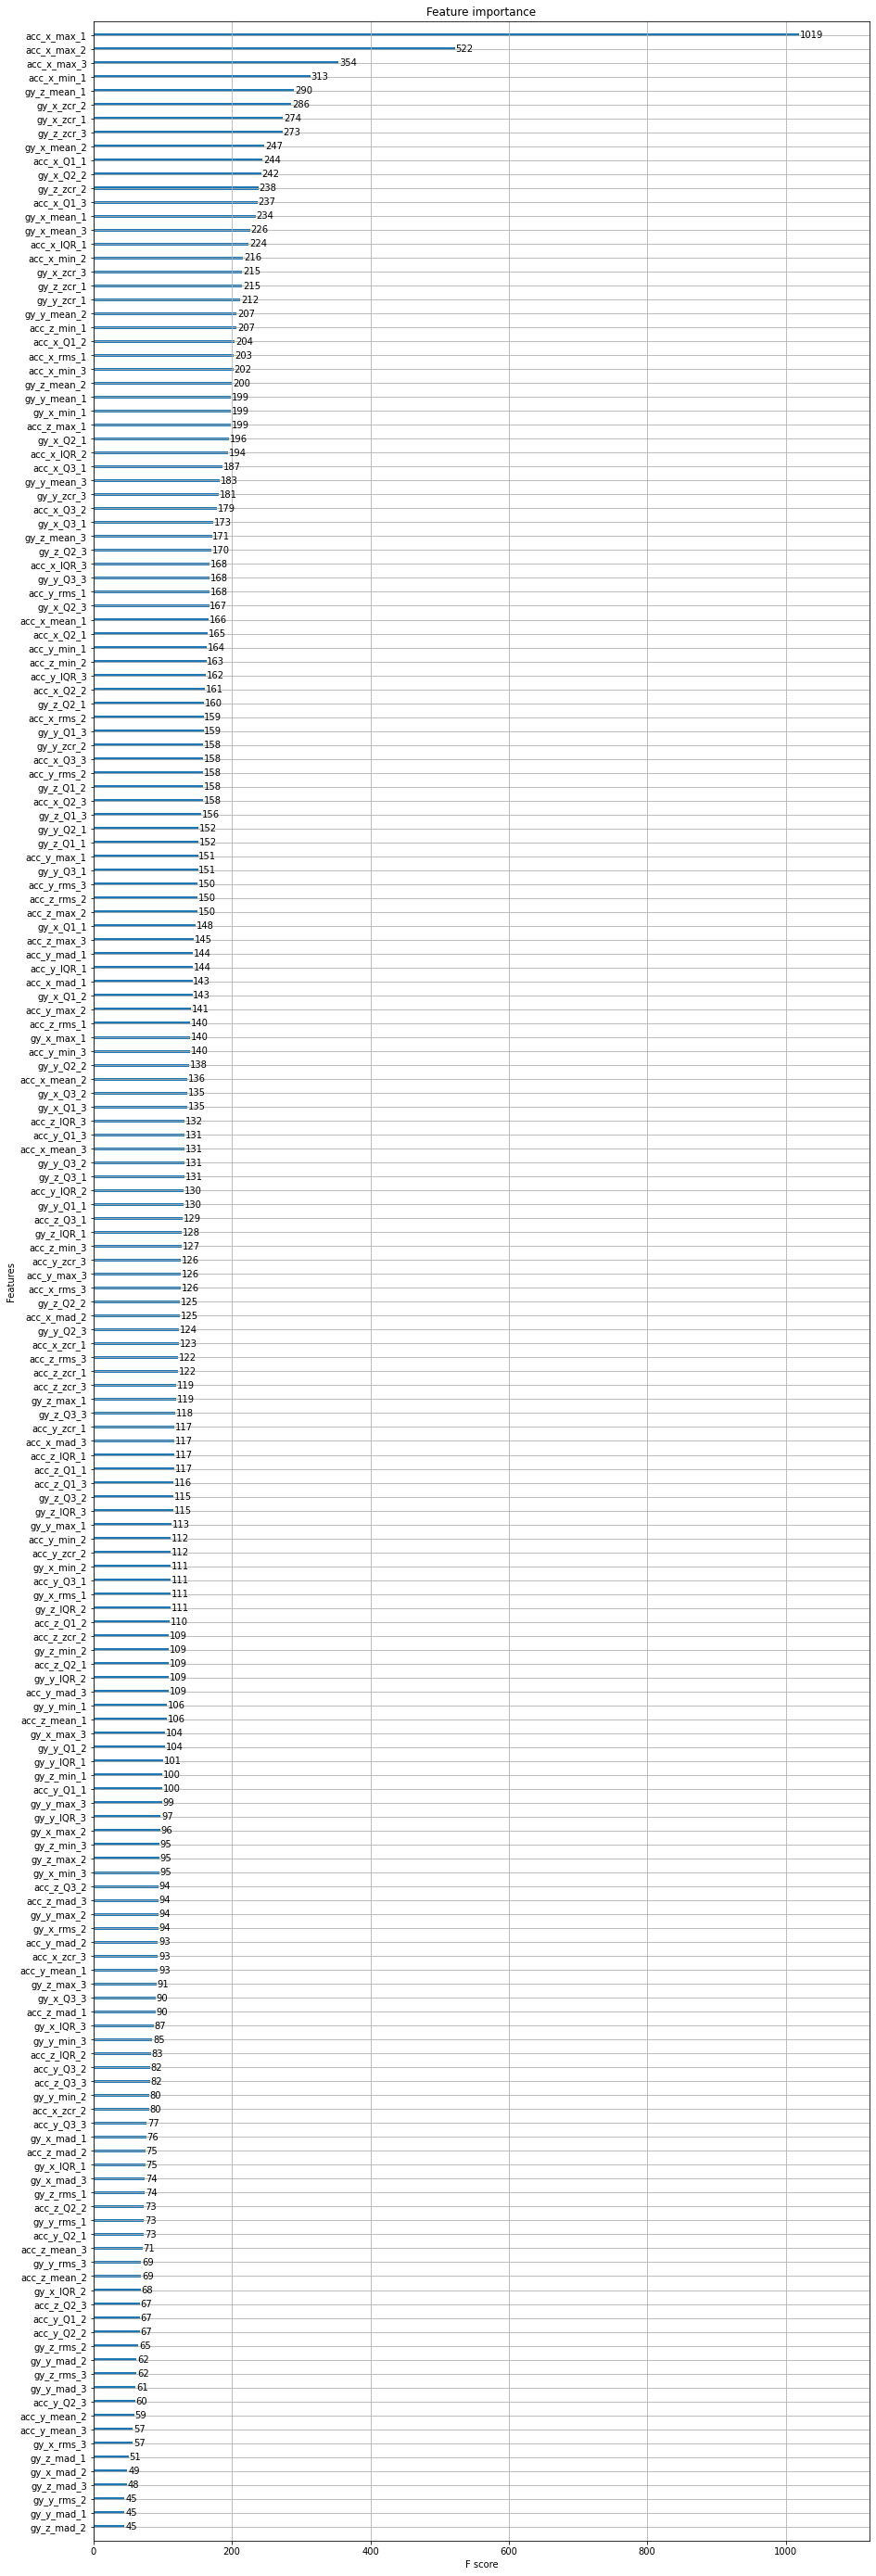

In [ ]:
from xgboost import plot_importance

fig, ax = plt.subplots(1,1,figsize=(15,50))
plot_importance(model, ax = ax)

그리고 이 때 xgboost의 plot_importance를 통해 xgboost 분류기의 특성 중요도를 시각화하였다. 이는 각 feature마다 xgboost에서의 중요도를 나타낸 plot으로 acc_x_max_1이 가장 높은 중요도를 보이고 있음을 알 수 있다. 이어서 acc_x_max_2와 axx_x_max_3 즉, max값이 가장 높은 중요도를 보이고 있고 그 뒤로는 큰 변화폭 없이 순서대로 그 중요도가 줄고 있음을 확인할 수 있다.

# 최종 제출

oof 방식의 XGBClassifier 보다 전체 데이터를 통하여 학습한 XGBClassifier의 결과가 더 좋아서 전체 데이터를 기반으로 학습한 모델을 최종 모델로 결정했다.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import log_loss
from tqdm import tqdm_notebook

model = xgb.XGBClassifier(random_state = 22, 
                          tree_method='gpu_hist', 
                          predictor='gpu_predictor',
                          learning_rate = 0.1,
                          n_estimators = 300,
                          max_depth = 6,
                          min_child_weight = 3,
                          gamma = 0.4,
                          subsample = 0.7,
                          colsample_bytree = 0.6)

model.fit(train_features_3, train_mean_min_max_median_label)
test_proba = model.predict_proba(test_features_3)

In [ ]:
submission.iloc[:, 1:] = test_proba
submission.to_csv('XGBClassifier.csv', index=False)
submission.head()

id         0         1         2  ...        57        58        59        60
0  3125  0.000489  0.000240  0.000544  ...  0.000818  0.149449  0.000794  0.000500
1  3126  0.000041  0.000079  0.000048  ...  0.000212  0.000036  0.000115  0.000060
2  3127  0.005179  0.208314  0.002682  ...  0.000961  0.004157  0.039564  0.008244
3  3128  0.001246  0.000142  0.006665  ...  0.000487  0.000318  0.000462  0.000402
4  3129  0.000208  0.000022  0.000011  ...  0.000066  0.000013  0.000038  0.000033

[5 rows x 62 columns]

결과 : 0.66207